In [1]:
# +
from dataset.semi import SemiDataset
from model.semseg.deeplabv2 import DeepLabV2
from model.semseg.deeplabv3plus import DeepLabV3Plus
from model.semseg.pspnet import PSPNet
from utils import count_params, meanIOU, color_map, DiceCoefficient

from utilsf.loss_file import save_loss
# -

import argparse
from copy import deepcopy
import numpy as np
import os
import json
from PIL import Image
import torch
from torch.nn import CrossEntropyLoss, DataParallel, functional as F
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss, DataParallel, functional as F

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
semi_setting = 'kidney/1-3'
save_path = f'outdir/models/{semi_setting}'
pseudo_mask_path = f'outdir/pseudo_masks/{semi_setting}'
labeled_id_path = f'dataset/splits/{semi_setting}/labeled.txt'
reliable_id_path = f'outdir/reliable_ids/{semi_setting}'

# data_root = '/home/S312112021/dataset/0_data_dataset_voc_950'
data_root = 'data/0_data_dataset_voc_950'
batch_size = 4
crop_size = 224
plus = True
dataset ='kidney'

with open('voc_mask_color_map.json', 'r') as file:
    JsonData = json.load(file)
voc_mask_color_map = JsonData['voc_mask_color_map']

if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(pseudo_mask_path):
    os.makedirs(pseudo_mask_path)
if plus and reliable_id_path is None:
    exit('Please specify reliable-id-path in ST++.')

# valset = SemiDataset(dataset, data_root, 'val', 224, voc_mask_color_map)
valset = SemiDataset(dataset, data_root, 'val', 224)
valloader = DataLoader(valset, batch_size=4 if dataset == 'cityscapes' else 1,
                       shuffle=False, pin_memory=True, num_workers=4, drop_last=False)

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
image_path = 'outdir/pseudo_masks/kidney/1-3/1015394_3_DATE20170908_STD02_SER01_IMG047.png'
# 讀取影像
# image_path = "data/0_data_dataset_voc_950/SegmentationClassPNG/1863478_1_DATE20160218_STD01_SER01_IMG053.png"
mask = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# 檢查原始影像格式
print("Original mask shape:", mask.shape)
print("Mask min value:", mask.min())
print("Mask max value:", mask.max())


# 查看掩膜圖像中的所有唯一值及其出現次數
unique_values, counts = np.unique(mask, return_counts=True)

print("Unique values in the mask and their counts:")
for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")
    
# 確保掩膜數值範圍在 0 和 1 之間
binary_mask = (mask > 0).astype(np.uint8)

# 顯示原始影像和處理後的掩膜影像
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Processed Binary Mask")
plt.imshow(binary_mask, cmap='gray')

plt.show()

# 保存處理後的掩膜影像
processed_mask_path = "/mnt/data/processed_mask.png"
cv2.imwrite(processed_mask_path, binary_mask * 255)

print(f"Processed binary mask saved to {processed_mask_path}")


[ WARN:0@0.050] global loadsave.cpp:248 findDecoder imread_('outdir/pseudo_masks/kidney/1-3/1015394_3_DATE20170908_STD02_SER01_IMG047.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

In [11]:
MODE = 'train'
# MODE = 'semi_train'
trainset = SemiDataset(dataset, data_root, MODE, crop_size, labeled_id_path)
# reliable_ids_path = 'outdir/reliable_ids/kidney/1-3/reliable_ids.txt'
# trainset = SemiDataset(dataset, data_root, MODE, crop_size, 'dataset/splits/kidney/1-3/labeled.txt', 
#                        reliable_ids_path,
#                        'outdir/pseudo_masks/kidney/1-3')
trainset = SemiDataset(dataset, data_root, MODE, crop_size, labeled_id_path)

trainset.ids = 2 * trainset.ids if len(trainset.ids) < 200 else trainset.ids
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         pin_memory=True, num_workers=16, drop_last=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:562: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
def init_basic_elems():
    model_zoo = {'deeplabv3plus': DeepLabV3Plus, 'pspnet': PSPNet, 'deeplabv2': DeepLabV2}
    model = model_zoo['deeplabv3plus']('resnet18', 2 if dataset == 'kidney' else 19)

    head_lr_multiple = 10.0

    optimizer = SGD([{'params': model.backbone.parameters(), 'lr': 0.001},
                     {'params': [param for name, param in model.named_parameters()
                                 if 'backbone' not in name],
                      'lr': 0.001 * head_lr_multiple}],
                    lr=0.001, momentum=0.9, weight_decay=1e-4)

    model = DataParallel(model).cuda()

    return model, optimizer

In [13]:
model, optimizer = init_basic_elems()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, pred, targets, smooth=1):
        target_one_hot = F.one_hot(targets, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        target_one_hot = target_one_hot[:, 1:, :, :]
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        pred = pred[:, 1:, :, :]  # shape: (16, C-1, 224, 224), e.g. (16, 3, 224, 224) -> (16, 2, 224, 224)
        pred = F.sigmoid(pred)
        
        #flatten label and prediction tensors
        pred_flat = pred.contiguous().view(-1)
        target_flat = target_one_hot.contiguous().view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()

        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice

In [15]:
criterion = DiceLoss()

In [16]:
for img, mask in trainloader:
    img, mask = img.to(device), mask.to(device)
    pred = model(img)  
    break

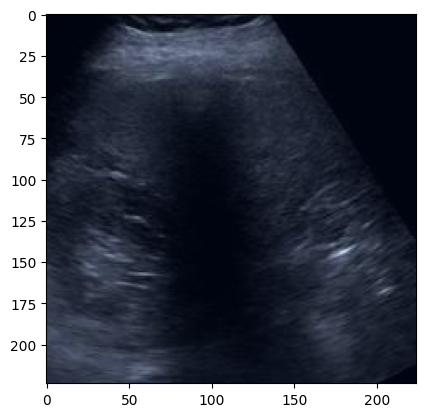

In [17]:
# 假設 img 是 PyTorch 張量，其形狀為 (3, 224, 224)
img = img[0].permute(1, 2, 0)  # 將形狀轉換為 (224, 224, 3)

# 將張量移動到 CPU 並轉換為 NumPy 陣列
img = img.cpu().numpy()
img = (img - img.min()) / (img.max() - img.min())

plt.imshow(img)  # 在圖表中繪製圖片
plt.show()

In [18]:
print('img shape: ', img.shape)
print('mask shape: ', mask.shape)
print('pred shape: ', pred.shape)

# 檢查 masks 的最小值和最大值
print('mask min value: ', mask.min().item())
print('mask max value: ', mask.max().item())

print('pred min value: ', pred.min().item())
print('pred max value: ', pred.max().item())

img shape:  (224, 224, 3)
mask shape:  torch.Size([4, 224, 224])
pred shape:  torch.Size([4, 2, 224, 224])
mask min value:  0
mask max value:  1
pred min value:  -2.2173380851745605
pred max value:  1.6006464958190918


In [19]:
loss = criterion(pred, mask)

print('Loss: ', loss.item())

Loss:  0.825101912021637


In [20]:
def pltPred(input):
    # 可視化 pred_classes 的第一個樣本
    one_pred = input[0].detach().cpu().numpy()

    # 獲取兩個 channel
    pred_class_sample1 = one_pred[0]
    pred_class_sample2 = one_pred[1]

    # 創建一個圖形窗口，包含兩個子圖
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # 顯示第一個 channel
    axes[0].imshow(pred_class_sample1, cmap='viridis')
    axes[0].set_title('Predicted Classes - Channel 1')

    # 顯示第二個 channel
    axes[1].imshow(pred_class_sample2, cmap='viridis')
    axes[1].set_title('Predicted Classes - Channel 2')

    plt.show()

In [21]:
one_mask = F.one_hot(mask, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

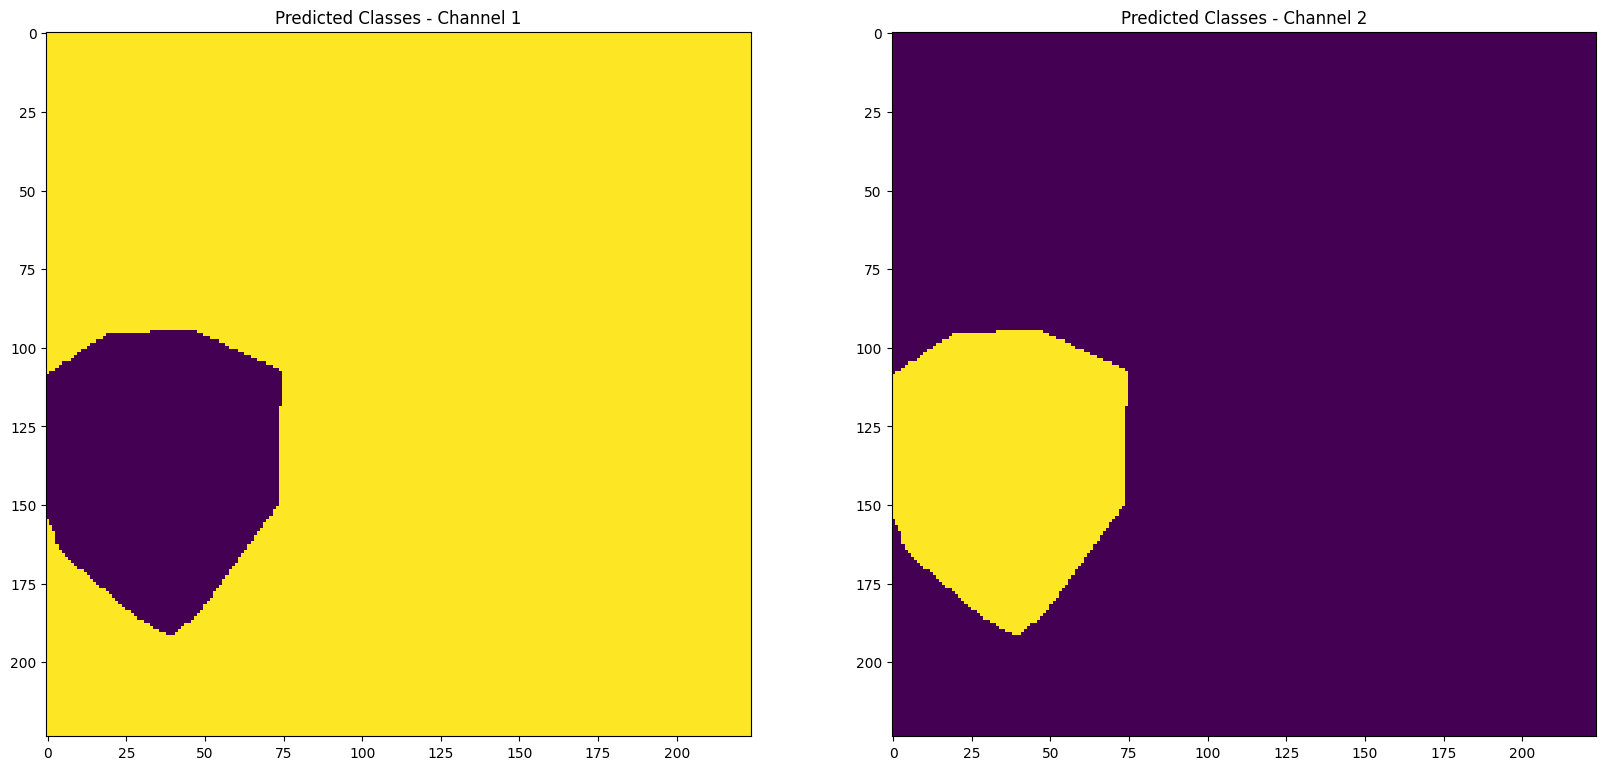

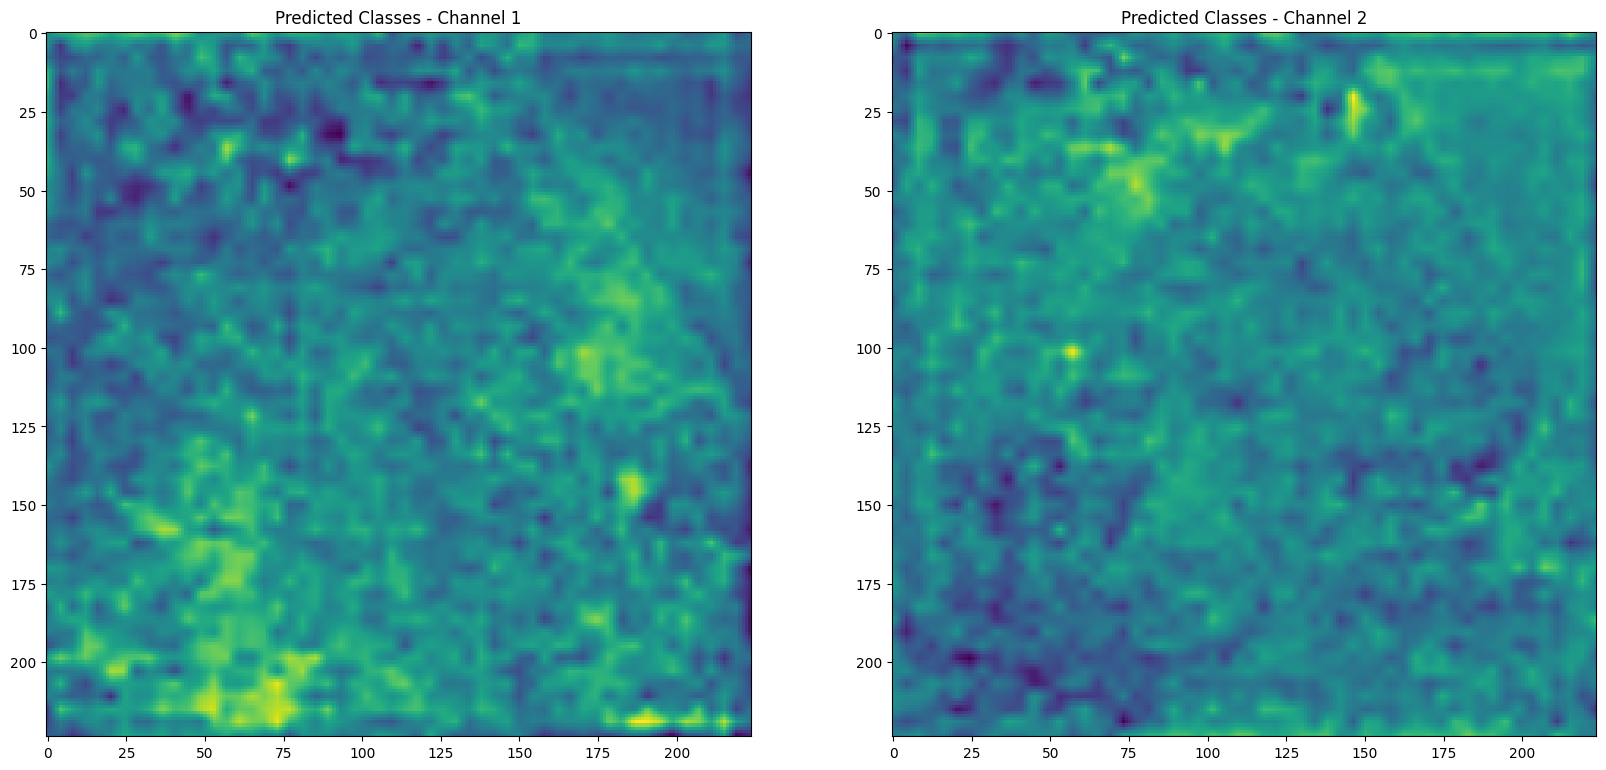

In [22]:
pltPred(one_mask)
pltPred(pred)